<a href="https://colab.research.google.com/github/AmerigoGiommetti/MLSA-code-summarization/blob/master/python_code_summarization_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
"""
ML-Based Python Code Summarization
Course: Machine Learning for Software Analysis

This project implements a machine learning model that generates
natural language summaries from Python code snippets.

Author: Amerigo Giommetti
Academic Year: 2025/2026
"""


'\nML-Based Python Code Summarization\nCourse: Machine Learning for Software Analysis\n\nThis project implements a machine learning model that generates\nnatural language summaries from Python code snippets.\n\nAuthor: Amerigo Giommetti\nAcademic Year: 2025/2026\n'

In [40]:
# ============================================================
# 1. Imports and Global Configuration
# ============================================================

#Tutte le librerie standard che serviranno per il progetto
import random
import math
import time

#Librerie necessarie per la manipolazione dei dati
import numpy as np
import pandas as pd

#Librerie necessarie per il machine learning
import torch
import torch.nn as nn
import torch.optim as optim

#Libreria per il plotting e l'evaluation
import matplotlib.pyplot as plt
from tqdm import tqdm as tdqm
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#Scelta della CPU o della GPU per processare i dati
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

SEED = 42                 #Seed per la riproducibilità dei risultati
BATCH_SIZE = 32           #Quanti dati si prendono alla volta
EMBEDDING_DIM = 128       #Complessità della rappresentazione che il modello fa dei dati
HIDDEN_DIM = 256          #Quantità di informazioni che il modello tiene ad ogni passaggio
NUM_EPOCHS = 15           #Numero di volte che i dati vengono processati
LEARNING_RATE = 1e-3      #Velocità con cui il modello impara
MAX_CODE_LEN = 200        #Lunghezza massima degli input di codice
MAX_SUMMARY_LEN = 75      #Lunghezza massima delle frasi summarization
MAX_SAMPLES = 5000        #Lunghezza massima del dataset per il training

Using device: cuda


In [23]:
# ============================================================
# 2. Reproducibility and Utility Functions
# ============================================================

#Setta lo stesso seed per tutti i processi random del modello
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#Il seed che viene usato è quello definito sopra
set_seed(SEED)

#Helper function per l'aggiunta di padding negli input troppo corti
def pad_sequence(seq, max_len, pad_value=0):
    return seq[:max_len] + [pad_value] * max(0, max_len - len(seq))


In [24]:
# ============================================================
# 3. Dataset Loading and Preprocessing
# ============================================================

#Primo dataset "giocattolo" per il test end to end della pipeline
toy_data = [
    ("def add(x, y): return x + y", "returns the sum of two numbers"),
    ("def sub(x, y): return x - y", "returns the difference of two numbers"),
    ("def mul(x, y): return x * y", "returns the product of two numbers"),
]
#Divisione del dataset in input e target
codes, summaries = zip(*toy_data)

# ===========================================================================
# 3. Dataset Loading code_x_glue (Direct Download from S3/GitHub Source)
# ===========================================================================

#import per il dataset di huggingface
from datasets import load_dataset
#import per il train test split
from sklearn.model_selection import train_test_split

def load_data_final():
    print("Caricamento dataset CodeXGLUE (Python)...")
    # Questo dataset è la versione pulita e stabile per Code Summarization
    dataset = load_dataset("code_x_glue_ct_code_to_text", "python")

    # Prendiamo lo split di train e lo trasformiamo in DataFrame
    train_data = dataset['train'].select(range(5000)) # Limite a 5000 per velocità

    df = pd.DataFrame({
        'code': train_data['code'],
        'summary': train_data['docstring']
    })

    # Pulizia (come da Lecture 7)
    df['code'] = df['code'].str.replace(r'\s+', ' ', regex=True).str.strip()
    df['summary'] = df['summary'].str.replace(r'\s+', ' ', regex=True).str.strip()

    return df

train_df = load_data_final()
print(f"Dataset caricato! Righe: {len(train_df)}")
print(f"Esempio Summary: {train_df['summary'].iloc[0]}")


Caricamento dataset CodeXGLUE (Python)...
Dataset caricato! Righe: 5000
Esempio Summary: Set the text for this element. Arguments: text (str): The text cls (str): The class of the text, defaults to ``current`` (leave this unless you know what you are doing). There may be only one text content element of each class associated with the element.


In [25]:
# ============================================================
# 4. Vocabulary and Tokenization
# ============================================================

#Definizione delle parole speciali
SPECIAL_TOKENS = {
    "<pad>": 0,       #per la normalizzazione della lunghezza
    "<sos>": 1,       #start of sequence
    "<eos>": 2,       #end of sequence
    "<unk>": 3        #per parole assenti dal vocabolario
}

#Libreria per le espressioni regolari per la tokenizzazione del codice
import re

# tokenizzazione delle frasi usando parole
# e qualsiasi tipo di carattere speciale diverso
# dallo spazio come input diviso
def tokenize(sentence):
    sentence = sentence.lower()
    tokens = re.findall(r"\w+|[^\w\s]", sentence)
    return tokens

# Creazione del vocabolario con tutte le parole speciali e tutte
# quelle presenti nell'input di training
def build_vocab(sentences):
    vocab = dict(SPECIAL_TOKENS)
    for sent in sentences:
        for token in tokenize(sent):
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

#Creazione di due vocabolari distinti per il codice e per il linguaggio naturale
code_vocab = build_vocab(train_df['code'])
summary_vocab = build_vocab(train_df['summary'])

# Encoding delle sequenze in input in numeri secondo i vocabolari appena creati
def encode(sentence, vocab, max_len):
    tokens = tokenize(sentence)
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    ids = [vocab["<sos>"]] + ids + [vocab["<eos>"]]
    return pad_sequence(ids, max_len, vocab["<pad>"])

#Creazione dei tensor che serviranno per il machine learning
print("Encoding del codice...")
X = torch.tensor([encode(c, code_vocab, MAX_CODE_LEN) for c in tdqm(train_df['code'])]).to(DEVICE)
print("Encoding del summary...")
Y = torch.tensor([encode(s, summary_vocab, MAX_SUMMARY_LEN) for s in tdqm(train_df['summary'])]).to(DEVICE)


Encoding del codice...


100%|██████████| 5000/5000 [00:00<00:00, 12876.64it/s]


Encoding del summary...


100%|██████████| 5000/5000 [00:00<00:00, 34462.14it/s]


In [26]:
# ============================================================
# 5. Model Definition
# ============================================================

class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True)

    def forward(self, x):
        emb = self.embedding(x)
        # encoder_outputs contiene tutte le informazione per l'attention
        encoder_outputs, (h, c) = self.lstm(emb)
        return encoder_outputs, h, c


class Decoder(nn.Module):
    def __init__(self, vocab_size, attention):
        super().__init__()
        self.attention = attention
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        # L'input dell'LSTM ora riceve Embedding + Vettore di Contesto
        self.lstm = nn.LSTM(HIDDEN_DIM + EMBEDDING_DIM, HIDDEN_DIM, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM * 2 + EMBEDDING_DIM, vocab_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        # x: [batch_size, 1]
        emb = self.embedding(x) # [batch, 1, emb_dim]

        # 1. Calcolo dei pesi di attenzione
        a = self.attention(hidden, encoder_outputs) # [batch, src_len]
        a = a.unsqueeze(1) # [batch, 1, src_len]

        # 2. Creazione del vettore di contesto (media pesata degli output encoder)
        weighted = torch.bmm(a, encoder_outputs) # [batch, 1, hidden_dim]

        # 3. Concatenazione di input + contesto per l'LSTM
        rnn_input = torch.cat((emb, weighted), dim=2)
        out, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        # 4. Predizione finale usando out, contesto e embedding originale
        prediction = self.fc(torch.cat((out, weighted, emb), dim=2))

        return prediction.squeeze(1), hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Otteniamo tutti gli output dall'encoder
        encoder_outputs, hidden, cell = self.encoder(src)

        input = trg[:, 0]

        for t in range(1, trg_len):
            # Passiamo encoder_outputs ad ogni step
            output, hidden, cell = self.decoder(input.unsqueeze(1), hidden, cell, encoder_outputs)
            outputs[:, t, :] = output

            top1 = output.argmax(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else top1

        return outputs

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Strati per calcolare l'energia (importanza) tra decoder e encoder
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [1, batch_size, hidden_dim] (stato attuale decoder)
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # Ripetiamo l'hidden state per ogni parola del codice in input
        hidden = hidden.repeat(src_len, 1, 1).transpose(0, 1) # [batch, src_len, hidden_dim]

        # Calcolo dell'allineamento (energia)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2) # [batch, src_len]

        # Softmax per avere pesi che sommano a 1
        return torch.softmax(attention, dim=1)


Epoch 1/15 - Loss: 6.0039
Epoch 2/15 - Loss: 5.2327
Epoch 3/15 - Loss: 4.8801
Epoch 4/15 - Loss: 4.5071
Epoch 5/15 - Loss: 4.0174
Epoch 6/15 - Loss: 3.4296
Epoch 7/15 - Loss: 2.9096
Epoch 8/15 - Loss: 2.3924
Epoch 9/15 - Loss: 1.9867
Epoch 10/15 - Loss: 1.5470
Epoch 11/15 - Loss: 1.2241
Epoch 12/15 - Loss: 1.0321
Epoch 13/15 - Loss: 0.7967
Epoch 14/15 - Loss: 0.6022
Epoch 15/15 - Loss: 0.4704


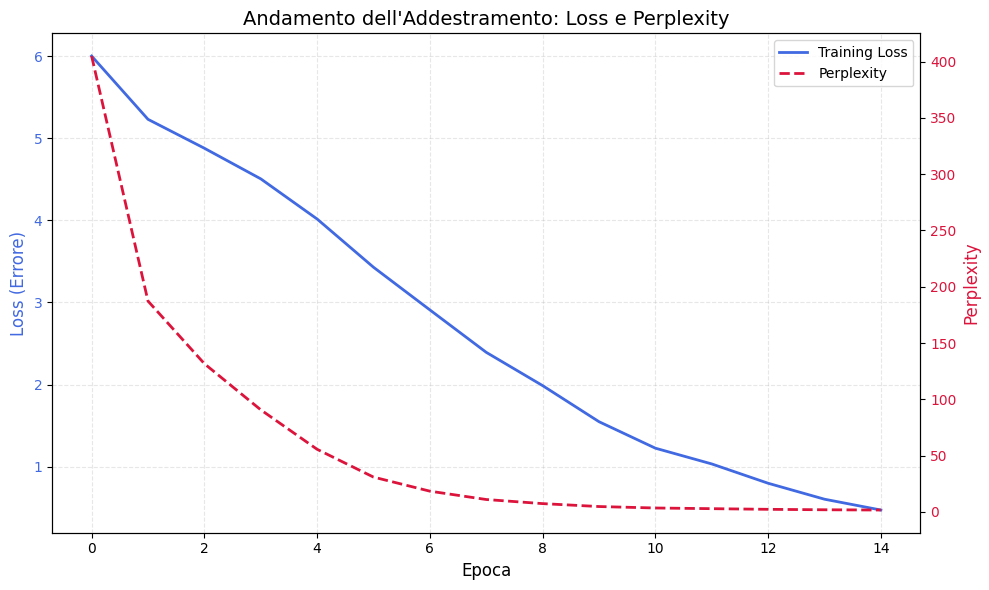

In [50]:
# ============================================================
# 6. Training Loop
# ============================================================

#Import necessario per il dataloader
from torch.utils.data import TensorDataset, DataLoader

#Usiamo il dataloader per non passare tutto il dataset in una volta
#Che potrebbe risultare in impossibilità di computazione per la CPU
dataset = TensorDataset(X, Y)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#Questa variabile ci servirà per plottare la loss
train_losses = []

#Inizializzazione dell'encoder e del decoder, optimizer e loss
attn = Attention(HIDDEN_DIM)
enc = Encoder(len(code_vocab)).to(DEVICE)
dec = Decoder(len(summary_vocab), attn).to(DEVICE)
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0) #ignora il padding

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()

        # Ora passiamo tutto al modello Seq2Seq.
        # Lui si occuperà di gestire l'encoder, il decoder e il teacher forcing internamente.
        # batch_y[:, :-1] sono gli input per il decoder (<sos> + parole)
        # batch_y[:, 1:]  sono i target che vogliamo predire (parole + <eos>)
        outputs = model(batch_x, batch_y)

        # Il primo token dell'output (tempo 0) è zero o non usato,
        # confrontiamo dal tempo 1 in poi
        output_dim = outputs.shape[-1]

        # Flattening per la CrossEntropy:
        # [batch, seq_len, vocab] -> [batch * seq_len, vocab]
        loss = criterion(
            outputs[:, 1:, :].reshape(-1, output_dim),
            batch_y[:, 1:].reshape(-1)
        )

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss) #Salviamo la loss media di questo epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss/len(train_loader):.4f}")

# Calcoliamo la perplexity per ogni epoca dalle loss salvate
train_perplexity = [np.exp(l) for l in train_losses]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primo asse: Loss
color = 'royalblue'
ax1.set_xlabel('Epoca', fontsize=12)
ax1.set_ylabel('Loss (Errore)', fontsize=12, color=color)
ax1.plot(train_losses, color=color, linewidth=2, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.3)

# Secondo asse: Perplexity
ax2 = ax1.twinx() # Crea un secondo asse che condivide lo stesso asse X
color = 'crimson'
ax2.set_ylabel('Perplexity', fontsize=12, color=color)
ax2.plot(train_perplexity, color=color, linewidth=2, linestyle='--', label='Perplexity')
ax2.tick_params(axis='y', labelcolor=color)

# Titolo e legenda
plt.title('Andamento dell\'Addestramento: Loss e Perplexity', fontsize=14)
fig.tight_layout() # Per evitare sovrapposizioni tra le etichette degli assi

# Uniamo le legende dei due assi
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()


In [47]:
# ============================================================
# 7. Inference / Code Summarization
# ============================================================

def summarize_code(model, code_sentence, src_vocab, tgt_vocab, max_len=MAX_SUMMARY_LEN):
    model.eval()
    with torch.no_grad():
        # 1. Preprocessing del codice in input
        tokens = tokenize(code_sentence)
        ids = [src_vocab.get(tok, src_vocab["<unk>"]) for tok in tokens]
        ids = [src_vocab["<sos>"]] + ids + [src_vocab["<eos>"]]
        src_tensor = torch.tensor(ids).unsqueeze(0).to(DEVICE) # [1, seq_len]

        # 2. Encoder: otteniamo TUTTI gli output per l'attenzione
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

        # 3. Preparazione generazione
        inputs = [tgt_vocab["<sos>"]]

        for i in range(max_len):
            input_tensor = torch.tensor([inputs[-1]]).to(DEVICE) # Ultimo token generato

            # 4. Decoder con Attention
            # Passiamo anche encoder_outputs
            output, hidden, cell = model.decoder(
                input_tensor.unsqueeze(0),
                hidden,
                cell,
                encoder_outputs
            )

            # Prendiamo la parola più probabile
            predicted_id = output.argmax(1).item()
            inputs.append(predicted_id)

            # Se il modello decide di chiudere la frase
            if predicted_id == tgt_vocab["<eos>"]:
                break

        # 5. Traduzione da ID a parole
        inv_vocab = {v: k for k, v in tgt_vocab.items()}
        summary_tokens = [inv_vocab.get(idx, "<unk>") for idx in inputs
                          if idx not in [SPECIAL_TOKENS["<sos>"], SPECIAL_TOKENS["<eos>"], SPECIAL_TOKENS["<pad>"]]]

        return " ".join(summary_tokens)

# Creiamo un dizionario inverso per decodificare (ID -> Parola)
tgt_vocab_inv = {v: k for k, v in summary_vocab.items()}

#================================================================
# Confronto tra frasi attese e frasi prodotte
#================================================================
def run_test_samples(n=5):
    print(f"{'CODICE ORIGINALE':<50} | {'RIASSUNTO REALE':<30} | {'GENERATO'}")
    print("-" * 130)

    # Usiamo train_df (o val_df se l'hai creato) per recuperare i testi
    for i in range(n):
        idx = random.randint(0, len(train_df)-1)
        original_code = train_df.iloc[idx]['code']
        real_summary = train_df.iloc[idx]['summary']

        generated_summary = summarize_code(model, original_code, code_vocab, summary_vocab)

        # Visualizzazione formattata
        short_code = (original_code[:47] + '...') if len(original_code) > 47 else original_code
        short_real = (real_summary[:27] + '...') if len(real_summary) > 27 else real_summary

        print(f"{short_code:<50} | {short_real:<30} | {generated_summary}")

# Eseguiamo il test
run_test_samples(n=5)


CODICE ORIGINALE                                   | RIASSUNTO REALE                | GENERATO
----------------------------------------------------------------------------------------------------------------------------------
def string_list_to_array(l): """ Turns a Python... | Turns a Python unicode stri... | turns a python unicode string list into a a string array . : param : : string string : the string list : type : list : list : string array : return : jb_object
def getDBusEnvEndpoints(reactor, client=True): ... | Creates endpoints from the ... | creates endpoints from the dbus_session_bus_address environment variable @ @ rtype : c { list list of } { twisted . . . . } . . } . } . } . } . returns : list of output of " " " " " . . . . . . ( " ( " ' , ' ) , " ( " ) , " jsonrpc . if ( " ' , ' )
def create_traj_ranges(start, stop, N): """ Fil... | Fills in the trajectory ran... | fills in the trajectory range . : return : from : / / / . com / a / 40624614
def adapt_for_peptides(self): 

In [49]:
# ============================================================
# 8. Evaluation Metrics
# ============================================================

#=============================================================
# BLEU & ROGUE SCORE
#=============================================================
from tqdm.auto import tqdm
from rouge_score import rouge_scorer

def calculate_metrics_complete(model, test_df, src_vocab, tgt_vocab, n_samples=100):
    model.eval()
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    bleu_scores = []
    rouge_l_scores = []

    samples = test_df.sample(n=min(n_samples, len(test_df)))

    for _, row in tqdm(samples.iterrows(), total=len(samples)):
        gen_sum = summarize_code(model, row['code'], src_vocab, tgt_vocab)
        real_sum = row['summary']

        # BLEU (quello che abbiamo già)
        ref = [tokenize(real_sum)]
        cand = tokenize(gen_sum)
        bleu_scores.append(sentence_bleu(ref, cand, smoothing_function=SmoothingFunction().method1))

        # ROUGE-L
        scores = scorer.score(real_sum, gen_sum)
        rouge_l_scores.append(scores['rougeL'].fmeasure)

    print(f"BLEU Medio: {sum(bleu_scores)/len(bleu_scores):.4f}")
    print(f"ROUGE-L Medio: {sum(rouge_l_scores)/len(rouge_l_scores):.4f}")

avg_score = calculate_metrics_complete(model, train_df, code_vocab, summary_vocab, n_samples=100)

#=============================================================
# PERPLEXITY BASED ON TRAINING LAST LOSS
#=============================================================
# Per la Perplessità (usa l'ultima loss calcolata nel training):
import math
final_perplexity = math.exp(train_losses[-1])
print(f"Perplexity Finale: {final_perplexity:.4f}")




  0%|          | 0/100 [00:00<?, ?it/s]

BLEU Medio: 0.6222
ROUGE-L Medio: 0.7901
Perplexity Finale: 2.1452


In [30]:
# ============================================================
# 9. Main Execution
# ============================================================

print("Project execution completed.")


Project execution completed.
